MFRevamp Project Bug analysis

Number of bugs :- 456
Number of Attributes/Columns in data: 4


Attribute Information :
1. BugId
2. Subject
3. start date
4. close date/end date

Objective : Given bug subject(one line descirption),determine for which module has more bugs raiseing by tester. 


[Q] How to determine for which module has more bugs raiseing by tester



[Ans] we could use subject line, by nlp tokenization we convert subject into words and by word frequency we can identiy which words(modules name occurs) mostly. by this we can identiy which moule has more bugs raised by tester. 

[Q].Why is solving this problem useful for your team?

[Ans]This can be used in middle of projects. we can use this for weekly basis bugs, for every week we can upload weekly bugs file and can analys which module has more or which has less so we can determine which module ready for production deployment.useful also for development team for identiying modules efficency.. also we can idnetify bugs type UI, funtional, multibrowser..

[Q]Metric used

we are doing analysis by graph of word(module name) counting

[Q]what is Business impact of deploying these models.


we can use this for weekly basis bugs, for every week we can upload weekly bugs file and can analys which module has more or which has less so we can determine which module ready for production deployment.useful also for development team for identiying modules efficency.. also we can idnetify bugs type UI, funtional, multibrowser..

In [14]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle

from tqdm import tqdm
import os

In [15]:
df = pd.read_csv("G:\machine_learning\mfrevamp.csv",encoding="ISO-8859-1")   #read weather.csv data
df

,#,Subjects,Start date,Close Date
0,25581,Quick invest page for sip,29-Oct-21,08-Nov-21
1,25579,Data is missing on Videos page for lumpsum,29-Oct-21,01-Nov-21
2,25577,Mf fund detail page for sell,29-Oct-21,02-Nov-21
3,25575,Heading is not displayed for swp,29-Oct-21,08-Nov-21
4,25569,UI for holding type on cart page for sell,29-Oct-21,30-Oct-21
...,...,...,...,...
451,7321,By default Mutual Fund tab not showing as sele...,19-Jan-21,20-Aug-21
452,5769,"CMS - Accepts invalid inputs in name, designat...",16-Dec-20,16-Dec-20
453,5744,CMS(About us) - image not displayed on website,16-Dec-20,16-Dec-20
454,5664,Minimum scroll bar amount displayed in textbo...,14-Dec-20,19-Mar-21


In [16]:
# printing some random reviews
sent_0 = df['Subjects'].values[0]
print(sent_0)
print("="*50)

sent_100 = df['Subjects'].values[100]
print(sent_100)
print("="*50)

sent_200 = df['Subjects'].values[200]
print(sent_200)
print("="*50)

sent_300 = df['Subjects'].values[300]
print(sent_300)
print("="*50)

sent_400 = df['Subjects'].values[400]
print(sent_400)
print("="*50)

 Quick invest page for sip
Schedule investment - SIP - Status column should be displayed 
Distributor details for sell 
Reports text label is not displayed properly 
URN number should not be displayed if transaction is failed


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't",'not'])

In [19]:
from tqdm import tqdm     
final_string=[]

for sentance in tqdm(df['Subjects'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    #sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)         
    final_string.append(sentance.strip())
    df['CleanedText']=pd.DataFrame(final_string)
    #df['CleanedText']=df['CleanedText'].str.decode("utf-8")
    

100%|███████████████████████████████████████| 456/456 [00:00<00:00, 462.86it/s]


In [20]:
final_string

['quick invest page sip',
 'data missing videos page lumpsum',
 'mf fund detail page sell',
 'heading displayed swp',
 'ui holding type cart page sell',
 'ui cart page aligned properly sell',
 'tools ui issue stp',
 'ui proper iphone sip',
 'blackstrip menus missing sell',
 'sub menus displayed ipad different sub menus displayed chrome stp',
 'section repeated pms page orderbook',
 'etf page ui swp',
 'index fund page error swp',
 'index fund error lumpsum',
 'download section lumpsum',
 'nav dividend page ui sip',
 'fund detail page know functionality',
 'lumpsum cashflow page error',
 'stp ui issue',
 'distributor details updated sell',
 'quick invest ui issue',
 'text colour ipad',
 'dashboard page ipad',
 'no action performed clicking send icon sell',
 'newsletter accepts invalid email address stp',
 'sitemap issue sip',
 'bank details name bank error sip',
 'minor name displayed transaction pages swp',
 'sip booster page redirection stp',
 'ui cashflow different mac window system 

In [21]:
final_string[40]

'error nav page sip'

In [22]:
from nltk.tokenize import word_tokenize
ac = []
for i in range(450):
    wordcount = word_tokenize(str(final_string[i]))
    ac.extend(wordcount)



In [23]:
ac

['quick',
 'invest',
 'page',
 'sip',
 'data',
 'missing',
 'videos',
 'page',
 'lumpsum',
 'mf',
 'fund',
 'detail',
 'page',
 'sell',
 'heading',
 'displayed',
 'swp',
 'ui',
 'holding',
 'type',
 'cart',
 'page',
 'sell',
 'ui',
 'cart',
 'page',
 'aligned',
 'properly',
 'sell',
 'tools',
 'ui',
 'issue',
 'stp',
 'ui',
 'proper',
 'iphone',
 'sip',
 'blackstrip',
 'menus',
 'missing',
 'sell',
 'sub',
 'menus',
 'displayed',
 'ipad',
 'different',
 'sub',
 'menus',
 'displayed',
 'chrome',
 'stp',
 'section',
 'repeated',
 'pms',
 'page',
 'orderbook',
 'etf',
 'page',
 'ui',
 'swp',
 'index',
 'fund',
 'page',
 'error',
 'swp',
 'index',
 'fund',
 'error',
 'lumpsum',
 'download',
 'section',
 'lumpsum',
 'nav',
 'dividend',
 'page',
 'ui',
 'sip',
 'fund',
 'detail',
 'page',
 'know',
 'functionality',
 'lumpsum',
 'cashflow',
 'page',
 'error',
 'stp',
 'ui',
 'issue',
 'distributor',
 'details',
 'updated',
 'sell',
 'quick',
 'invest',
 'ui',
 'issue',
 'text',
 'colour',
 'i

In [24]:
df

,#,Subjects,Start date,Close Date,CleanedText
0,25581,Quick invest page for sip,29-Oct-21,08-Nov-21,quick invest page sip
1,25579,Data is missing on Videos page for lumpsum,29-Oct-21,01-Nov-21,data missing videos page lumpsum
2,25577,Mf fund detail page for sell,29-Oct-21,02-Nov-21,mf fund detail page sell
3,25575,Heading is not displayed for swp,29-Oct-21,08-Nov-21,heading displayed swp
4,25569,UI for holding type on cart page for sell,29-Oct-21,30-Oct-21,ui holding type cart page sell
...,...,...,...,...,...
451,7321,By default Mutual Fund tab not showing as sele...,19-Jan-21,20-Aug-21,default mutual fund tab showing selected
452,5769,"CMS - Accepts invalid inputs in name, designat...",16-Dec-20,16-Dec-20,cms accepts invalid inputs name designation de...
453,5744,CMS(About us) - image not displayed on website,16-Dec-20,16-Dec-20,cms us image displayed website
454,5664,Minimum scroll bar amount displayed in textbo...,14-Dec-20,19-Mar-21,minimum scroll bar amount displayed textbox upto


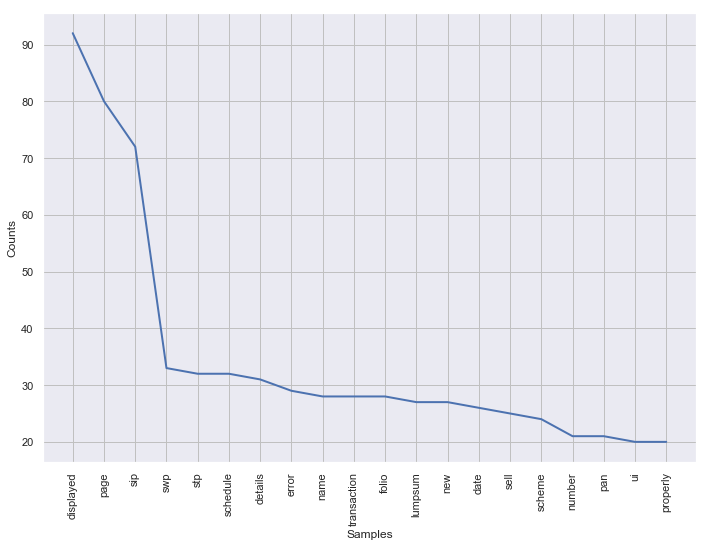

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('darkgrid')
nlp_words = nltk.FreqDist(ac)
nlp_words.plot(20)            

by above graph, we can say that SIP,STP modules has more bugs, this modules are not stable. this modules are not ready for production deployment